# Deep Learning - End Semester Exam

## **Research Paper Implementation:**

### Interpretable part-whole hierarchies and conceptual-semantic relationships inneural networks

    Ayush Abrol B20AI052

---


#### Published in CVPR'22

#### Authors of University of Trento - Department of Information Engineering and Computer Science - DISIVia Sommarive, 9, 38123 Povo, Trento TN:

    - Nicola Garau
    - Niccol ́o Bisagno
    - Zeno Sambugaro
    - Nicola Conci


### Necessary Imports


In [ ]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import errno
import struct
from itertools import groupby
from os import makedirs
from os.path import join, exists
import warnings
import math
from typing import Tuple, Any, Callable, Optional, Union 
from functools import partial
from tqdm import tqdm
from PIL import Image

from einops.einops import reduce, rearrange
from einops.layers.torch import Rearrange
from einops import rearrange, repeat

from absl import flags

import torch
from torch import einsum
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms, utils, models
from torchvision.datasets.utils import download_url, check_integrity

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger

import warnings
warnings.filterwarnings("ignore")

### Setting up the device to GPU

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Check if GPU is available
device 

device(type='cuda')

### Defining the utility functions 

In [3]:
def count_parameters(model): # Count number of trainable parameters in the model
    return sum(p.numel() for p in model.parameters() if p.requires_grad) 

def exists(val): # Check if the value exists
    return val is not None

def default(val, d): # Return default value if the value does not exist
    return val if exists(val) else d

### Creating Two Crops of the same image

In [4]:
class TwoCropTransform: # Create two crops of the same image
    """Create two crops of the same image"""
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x):
        return [self.transform(x), self.transform(x)] # Return two crops of the same image

### Loss computation for the Agglomerator model

Computes loss for model. If both `labels` and `mask` are None, it degenerates to SimCLR unsupervised loss:

    Args:
        features: hidden vector of shape [bsz, n_views, ...].
        labels: ground truth of shape [bsz].
        mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
            has the same class as sample i. Can be asymmetric.

    Returns:
        A loss scalar.

In [5]:
class SupConLoss(nn.Module): # Supervised Contrastive Loss
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07): # Initialize the parameters
        super(SupConLoss, self).__init__() 
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature 

    def forward(self, features, labels=None, mask=None): # Forward pass

        if len(features.shape) < 3: # Check if the number of dimensions is less than 3
            raise ValueError('`features` needs to be [bsz, n_views, ...],' 
                             'at least 3 dimensions are required') # Raise error
        if len(features.shape) > 3: # Check if the number of dimensions is greater than 3
            features = features.view(features.shape[0], features.shape[1], -1) # Reshape the features

        batch_size = features.shape[0] # Get the batch size 
        if labels is not None and mask is not None: # Check if labels and mask are not None
            raise ValueError('Cannot define both `labels` and `mask`') # Raise error
        elif labels is None and mask is None:   # Check if labels and mask are None
            mask = torch.eye(batch_size, dtype=torch.float32).to(device) # Create a mask
        elif labels is not None: # Check if labels is not None
            labels = labels.contiguous().view(-1, 1) # Reshape the labels
            if labels.shape[0] != batch_size: # Check if the number of labels does not match the number of features
                raise ValueError('Num of labels does not match num of features') # Raise error
            mask = torch.eq(labels, labels.T).float().to(device) # Create a mask
        else:
            mask = mask.float().to(device) # Create a mask

        contrast_count = features.shape[1] # Get the number of contrastive features
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0) # Concatenate the features
        if self.contrast_mode == 'one': # Check if the contrast mode is one
            anchor_feature = features[:, 0] # Get the anchor features
            anchor_count = 1 # Set the anchor count to 1
        elif self.contrast_mode == 'all': # Check if the contrast mode is all
            anchor_feature = contrast_feature # Set the anchor features to contrast features
            anchor_count = contrast_count # Set the anchor count to contrast count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode)) # Raise error

        # Computing logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T), 
            self.temperature) # Compute the dot product
        # For Numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True) # Compute the maximum value
        logits = anchor_dot_contrast - logits_max.detach() # Compute the logits

        # Tile mask
        mask = mask.repeat(anchor_count, contrast_count) # Repeat the mask

        # Mask-out self-contrast cases
        logits_mask = torch.scatter( # Scatter the logits
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0 
        )
        mask = mask * logits_mask # Multiply the mask with logits mask

        # Compute log probabilities
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # Compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        # Loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

### Siren Class which basically returns the sinousoidal function

In [6]:
class Siren(pl.LightningModule):
    def __init__(self):
        super(Siren, self).__init__() # Initialize the model
    def forward(self,x):
        return torch.sin(x) # Sine activation function

In [7]:
from datetime import datetime

In [109]:
def plot_islands_agreement(levels, image): # Plot the agreement between the islands
    image_cpu = image.permute(1,2,0).detach().cpu().numpy() # Get the image
    lin = nn.Linear(levels.shape[-1], 2).cuda() # Linear layer
    levels_2 = lin(levels) # Linear layer
    levels_2 = rearrange(levels_2,'(w h) l a -> w h l a', w = int(math.sqrt(levels.detach().cpu().numpy().shape[0]))) # Rearrange the levels
    levels_cpu_2 = levels_2.detach().cpu().numpy() # Get the levels

    mylevels = [] # List of levels
    for l in range(levels_cpu_2.shape[2]): # Iterate over the levels
        mylevels.append(levels_cpu_2[:,:,l,:]) # Append the levels

    fig, axs = plt.subplots(1, len(mylevels) + 1) # Create the subplots
    plt.rcParams["figure.figsize"] = (25,3) # Set the figure size
    axs[-1].imshow(image_cpu) # Plot the image
    axs[-1].set_box_aspect(1) # Set the box aspect
    axs[-1].grid(False) # Disable the grid
    axs[-1].axes.xaxis.set_visible(False) # Disable the axes
    axs[-1].axes.yaxis.set_visible(False) 
    for i, matrice in enumerate(mylevels): # Iterate over the levels
        x = np.arange(0.5, matrice.shape[0], 1) # Get the x values
        y = np.arange(0.5, matrice.shape[0], 1) # Get the y values
        xx, yy = np.meshgrid(x, y) # Create the meshgrid
        r = np.power(np.add(np.power(matrice[:,:,0],2), np.power(matrice[:,:,1],2)),0.5) # Compute the radius
        axs[i].imshow(r, cmap='inferno', interpolation='nearest') # Plot the radius
        
        axs[i].set_box_aspect(1) # Set the box aspect
        axs[i].grid(False) # Disable the grid
        axs[i].axes.xaxis.set_visible(False) # Disable the axes
        axs[i].axes.yaxis.set_visible(False)

    plt.savefig(f'/workspace/plots/EMNIST/train/{datetime.now().strftime("%Y%m%d_%H%M%S")}.png') # Save the plot
    plt.close()

### Defining the config flags for the agglomerator model (CIFAR10 dataset)


In [9]:
flags.DEFINE_string('dataset', 'CIFAR10', 'Dataset name.') 
flags.DEFINE_string('exp_name', 'CIFAR10', 'Experiment name.')

### Network Parameters


In [10]:
flags.DEFINE_integer('patch_size', 1, 'Patch size.')
flags.DEFINE_integer('patch_dim', 128, 'Patch feature dimension.')
flags.DEFINE_integer('batch_size', 32, 'Batch size.')
flags.DEFINE_integer('levels', 2, 'Columns levels.')
flags.DEFINE_bool('supervise', False, 'Supervise training.')
flags.DEFINE_integer('image_size', 32, 'Input images size.')
flags.DEFINE_integer('conv_image_size', 8, 'Conv images size.')
flags.DEFINE_integer('n_channels', 3, 'Number of image channels.')
flags.DEFINE_integer('n_classes', 10, 'Number of classes.')
flags.DEFINE_integer('iters', None, 'Number of iterations for the columns (if None it will be set by the network).')
flags.DEFINE_integer('denoise_iter', -1, 'At which iteration to perform denoising.')
flags.DEFINE_float('dropout', 0.3, 'Dropout.')
flags.DEFINE_float('temperature', 0.07, 'Contrastive temperature.')
flags.DEFINE_integer('contr_dim', 512, 'Contrastive hidden dimension.')

### Training Parameters

In [11]:
flags.DEFINE_string('mode', 'train', 'train/test/freeze.')
flags.DEFINE_float('learning_rate', 0.05, 'Learning rate.')
flags.DEFINE_float('lr_speed', 2000, 'Learning rate scheduler speed.')
flags.DEFINE_boolean('resume_training', False,
                     'Resume training using a checkpoint.')
flags.DEFINE_string('load_checkpoint_dir', 'path_to_checkpoint.ckpt',
                    'Load previous existing checkpoint.')
flags.DEFINE_integer('seed', 42, 'Seed.')
flags.DEFINE_integer('max_epochs', 100, 'Number of training epochs.')
flags.DEFINE_float('weight_decay', 5e-4, 'Weight decay.')
flags.DEFINE_integer('num_workers', 8, 'Number of workers.')
flags.DEFINE_integer('num_gpus', 1, 'Number of gpus.')

flags.DEFINE_float('limit_train', 1.0, 'Limit train set.')
flags.DEFINE_float('limit_val', 1.0, 'Limit val set.')
flags.DEFINE_float('limit_test', 1.0, 'Limit test set.')

flags.DEFINE_bool('plot_islands', False, 'Plot islands of agreement.')

### Converting FLAGS to a dictionary

In [12]:
FLAGS = flags.FLAGS
FLAGS = FLAGS.flag_values_dict()

In [13]:
FLAGS

{'dataset': 'CIFAR10',
 'exp_name': 'CIFAR10',
 'patch_size': 1,
 'patch_dim': 128,
 'batch_size': 32,
 'levels': 2,
 'supervise': False,
 'image_size': 32,
 'conv_image_size': 8,
 'n_channels': 3,
 'n_classes': 10,
 'iters': None,
 'denoise_iter': -1,
 'dropout': 0.3,
 'temperature': 0.07,
 'contr_dim': 512,
 'mode': 'train',
 'learning_rate': 0.05,
 'lr_speed': 2000.0,
 'resume_training': False,
 'load_checkpoint_dir': 'path_to_checkpoint.ckpt',
 'seed': 42,
 'max_epochs': 100,
 'weight_decay': 0.0005,
 'num_workers': 8,
 'num_gpus': 1,
 'limit_train': 1.0,
 'limit_val': 1.0,
 'limit_test': 1.0,
 'plot_islands': False}

### Importing Dataset: CIFAR10 and transforming it to Tensors using the config in FLAGS

In [14]:
class CustomTransforms():
    def __init__(self, FLAGS):
        self.train_transforms = {} # Initialize the train transforms
        self.test_transforms = {}   # Initialize the test transforms

        self.FLAGS = FLAGS  # Get the flags

        self.train_transforms['CIFAR10'] = transforms.Compose([ # CIFAR10 train transforms
            transforms.Resize((self.FLAGS["image_size"], self.FLAGS["image_size"])), # Resize the image to 32x32
            transforms.RandAugment(), # RandAugment
            transforms.ToTensor(), # Convert to tensor
        ])

        self.test_transforms['CIFAR10'] = transforms.Compose([
            transforms.Resize((self.FLAGS["image_size"], self.FLAGS["image_size"])),    
            transforms.ToTensor(),
        ])

### Token attend self value (for the attention matrix)

In [15]:
TOKEN_ATTEND_SELF_VALUE = -5e-4

### Defining the Convolutional Tokenizer for the Agglomerator model

![architecture](https://github.com/ayushabrol13/Interpretable-part-whole-hierarchies-and-conceptual-semantic-relationships-in-neural-networks/blob/master/assets/architecture.png "Architecture of the Agglomerator model")

In [16]:
class ConvTokenizer(pl.LightningModule): # Convolutional tokenizer 
    def __init__(self, in_channels=3, embedding_dim=64): # Initialize the class
        super(ConvTokenizer, self).__init__() # Initialize the superclass
        self.block = nn.Sequential( # Creating the block
            nn.Conv2d(in_channels,  # Input channels
                      embedding_dim // 2, # Output channels
                      kernel_size=(3, 3), # Kernel size
                      stride=(2, 2), # Stride
                      padding=(1, 1), # Padding
                      bias=False), # Bias
            nn.BatchNorm2d(embedding_dim // 2), # Batch norm
            nn.ReLU(inplace=True), # ReLU activation
            nn.Conv2d(embedding_dim // 2,
                      embedding_dim // 2,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=(1, 1),
                      bias=False),
            nn.BatchNorm2d(embedding_dim // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(embedding_dim // 2,
                      embedding_dim,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=(1, 1),
                      bias=False),
            nn.BatchNorm2d(embedding_dim),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(3, 3),
                         stride=(2, 2),
                         padding=(1, 1),
                         dilation=(1, 1))
        )

    def forward(self, x):
        return self.block(x) # Return the block

### Defining the ColumnNet Class

It is a convolutional neural network that operates on a 4D tensor levels of shape (batch_size, num_levels, level_length, dim).

Then, a 1D convolutional layer is applied to the tensor, followed by normalization and activation. Another convolutional layer, normalization, and rearrangement are then applied. Finally, the output tensor is returned.

In [17]:
class ColumnNet(pl.LightningModule): 
    def __init__(self, FLAGS, dim, groups, mult = 4, activation = nn.GELU): # Initialize the class
        super().__init__() # Initialize the superclass
        self.FLAGS = FLAGS # Get the flags 
        total_dim = dim * groups # Get the total dimension
        num_patches = (self.FLAGS["conv_image_size"] // self.FLAGS["patch_size"]) ** 2 # Get the number of patches
         
        self.net = nn.Sequential( # Create the network
            Rearrange('b n l d -> b (l d) n'), # Rearrange the input
            nn.LayerNorm(num_patches), # Layer norm
            nn.Conv1d(total_dim, total_dim * mult, 1, groups = groups), # Convolution
            activation(), # Activation
            nn.LayerNorm(num_patches), # Layer norm 
            nn.Conv1d(total_dim * mult, total_dim, 1, groups = groups), # Convolution
            Rearrange('b (l d) n -> b n l d', l = groups) # Rearrange the input
        )

    def forward(self, levels):
        levels = self.net(levels) # Pass through the network
        return levels # Return the levels
    

### Consensus Attention Class

In [18]:
class ConsensusAttention(pl.LightningModule): 
    def __init__(self, num_patches_side, attend_self = True, local_consensus_radius = 0):
        super().__init__()
        self.attend_self = attend_self
        self.local_consensus_radius = local_consensus_radius

        if self.local_consensus_radius > 0:
            coors = torch.stack(torch.meshgrid(
                torch.arange(num_patches_side),
                torch.arange(num_patches_side)
            )).float()

            coors = rearrange(coors, 'c h w -> (h w) c')
            dist = torch.cdist(coors, coors)
            mask_non_local = dist > self.local_consensus_radius
            mask_non_local = rearrange(mask_non_local, 'i j -> () i j')
            self.register_buffer('non_local_mask', mask_non_local)

    def forward(self, levels):
        _, n, _, d, device = *levels.shape, levels.device
        q, k, v = levels, F.normalize(levels, dim = -1), levels

        sim = einsum('b i l d, b j l d -> b l i j', q, k) * (d ** -0.5)

        if not self.attend_self:
            self_mask = torch.eye(n, device = device, dtype = torch.bool)
            self_mask = rearrange(self_mask, 'i j -> () () i j')
            sim.masked_fill_(self_mask, TOKEN_ATTEND_SELF_VALUE)

        if self.local_consensus_radius > 0:
            max_neg_value = -torch.finfo(sim.dtype).max
            sim.masked_fill_(self.non_local_mask, max_neg_value)

        attn = sim.softmax(dim = -1)
        out = einsum('b l i j, b j l d -> b i l d', attn, levels)
        return out

### Function for initializing the notebook run

    - Ignore warnings
    - Enabling cuDNN
    - Enabling cuDNN benchmarking
    - Emptying the cuda cache

In [ ]:
def init_all(): # Intializing the notebook run
    warnings.filterwarnings("ignore") # Ignore warnings

    torch.backends.cudnn.enabled = True # Enable cuDNN
    torch.backends.cudnn.benchmark = True # Enable cuDNN benchmarking
    torch.cuda.empty_cache() # Empty cache

### Defining the Agglomerator class

In [20]:
class Agglomerator(pl.LightningModule):  # Agglomerator class
    def __init__(self, 
        FLAGS, *, consensus_self = False, local_consensus_radius = 0): 
        super(Agglomerator, self).__init__()
        self.FLAGS = FLAGS
        self.num_patches_side = (self.FLAGS["conv_image_size"] // self.FLAGS["patch_size"])
        self.num_patches =  self.num_patches_side ** 2
        self.features = []
        self.labels = []
        self.iters = default(self.FLAGS["iters"], self.FLAGS["levels"] * 2)
        self.batch_acc = 0

        self.wl = torch.nn.parameter.Parameter(torch.tensor(0.25, device=device), requires_grad=True)
        self.wBU = torch.nn.parameter.Parameter(torch.tensor(0.25, device=device), requires_grad=True)
        self.wTD = torch.nn.parameter.Parameter(torch.tensor(0.25, device=device), requires_grad=True)
        self.wA = torch.nn.parameter.Parameter(torch.tensor(0.25, device=device), requires_grad=True)

        self.image_to_tokens = nn.Sequential(
            ConvTokenizer(in_channels=self.FLAGS["n_channels"], embedding_dim=self.FLAGS["patch_dim"] // (self.FLAGS["patch_size"] ** 2)),
            Rearrange('b d (h p1) (w p2) -> b (h w) (d p1 p2)', p1 = self.FLAGS["patch_size"], p2 = self.FLAGS["patch_size"]),
        )

        self.contrastive_head = nn.Sequential(
            nn.LayerNorm(self.FLAGS["patch_dim"]),
            nn.Dropout(p=self.FLAGS["dropout"]),
            Rearrange('b n d -> b (n d)'),
            nn.LayerNorm(self.num_patches * self.FLAGS["patch_dim"]),
            nn.Dropout(p=self.FLAGS["dropout"]),
            nn.Linear(self.num_patches * self.FLAGS["patch_dim"], self.num_patches * self.FLAGS["patch_dim"]),
            nn.LayerNorm(self.num_patches * self.FLAGS["patch_dim"]),
            nn.GELU(),
            nn.LayerNorm(self.num_patches * self.FLAGS["patch_dim"]),
            nn.Dropout(p=self.FLAGS["dropout"]),
            nn.Linear(self.num_patches * self.FLAGS["patch_dim"], self.FLAGS["contr_dim"])
        )

        self.classification_head_from_contr = nn.Sequential(
            nn.Linear(self.FLAGS["contr_dim"], self.FLAGS["contr_dim"]),
            nn.GELU(),
            nn.Linear(self.FLAGS["contr_dim"], self.FLAGS["n_classes"])
        )

        self.init_levels = nn.Parameter(torch.randn(self.FLAGS["levels"], FLAGS["patch_dim"]))
        self.bottom_up = ColumnNet(self.FLAGS, dim = self.FLAGS["patch_dim"], activation=nn.GELU, groups = self.FLAGS["levels"])
        self.top_down = ColumnNet(self.FLAGS, dim = self.FLAGS["patch_dim"], activation=Siren, groups = self.FLAGS["levels"] - 1)
        self.attention = ConsensusAttention(self.num_patches_side, attend_self = consensus_self, local_consensus_radius = local_consensus_radius)

    def forward(self, img, levels = None):
        if (FLAGS["supervise"]):
            img = img[0]
        b, device = img.shape[0], img.device

        tokens = self.image_to_tokens(img)
        n = tokens.shape[1]

        bottom_level = tokens
        bottom_level = rearrange(bottom_level, 'b n d -> b n () d')

        if not exists(levels):
            levels = repeat(self.init_levels, 'l d -> b n l d', b = b, n = n)

        hiddens = [levels]

        num_contributions = torch.empty(self.FLAGS["levels"], device = device).fill_(4)
        num_contributions[-1] = 3 

        for _ in range(self.iters):
            levels_with_input = torch.cat((bottom_level, levels), dim = -2)

            bottom_up_out = self.bottom_up(levels_with_input[..., :-1, :])

            top_down_out = self.top_down(torch.flip(levels_with_input[..., 2:, :], [2]))
            top_down_out = F.pad(torch.flip(top_down_out, [2]), (0, 0, 0, 1), value = 0.)

            consensus = self.attention(levels)

            levels_sum = torch.stack((
                levels * self.wl, \
                bottom_up_out * self.wBU, \
                top_down_out * self.wTD, \
                consensus * self.wA
            )).sum(dim = 0)
            levels_mean = levels_sum / rearrange(num_contributions, 'l -> () () l ()')

            self.log('Weights/wl', self.wl)
            self.log('Weights/wBU', self.wBU)
            self.log('Weights/wTD', self.wTD)
            self.log('Weights/wA', self.wA)

            levels = levels_mean
            hiddens.append(levels)

        all_levels = torch.stack(hiddens)

        top_level = all_levels[self.FLAGS["denoise_iter"], :, :, -1]

        top_level = self.contrastive_head(top_level)
        top_level = F.normalize(top_level, dim=1)

        return top_level, all_levels[-1,0,:,:,:]

    def training_step(self, train_batch, batch_idx):
        image = train_batch[0]
        label = train_batch[1]
        self.training_batch_idx = batch_idx

        if(not self.FLAGS["supervise"]):
            image = torch.cat([image[0], image[1]], dim=0)

        if(self.FLAGS["supervise"]):
            with torch.no_grad():
                top_level, _ = self.forward(image)
                self.features.append(list(top_level.data.cpu().numpy()))
                self.labels.append(label.cpu().numpy())
        else:
            top_level, toplot = self.forward(image)
            if(self.FLAGS["plot_islands"]):
                plot_islands_agreement(toplot, image[0,:,:,:])

        if(self.FLAGS["supervise"]):
            output = self.classification_head_from_contr(top_level)
            loss = F.cross_entropy(output, label)
            self.batch_acc = self.accuracy(output.data,label,topk=(1,))[0]
            self.log('Training/accuracy', self.batch_acc, prog_bar=True, sync_dist=True)
            self.batch_acc = 0

        else:
            f1, f2 = torch.split(top_level, [self.FLAGS["batch_size"] // self.FLAGS["num_gpus"], self.FLAGS["batch_size"] // self.FLAGS["num_gpus"]], dim=0)
            output = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)
            criterion = SupConLoss(temperature=self.FLAGS["temperature"])
            loss = criterion(output, label)

        self.log('Training/loss', loss, sync_dist=True)
        self.log('Training/LR', self.optimizer.param_groups[0]['lr'], prog_bar=True, sync_dist=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        image = val_batch[0]
        label = val_batch[1]
        self.val_batch_idx = batch_idx

        if(not self.FLAGS["supervise"]):
            image = torch.cat([image[0], image[1]], dim=0)

        if(self.FLAGS["supervise"]):
            with torch.no_grad():
                top_level, _ = self.forward(image)
                self.features.append(list(top_level.data.cpu().numpy()))
                self.labels.append(label.cpu().numpy())
        else:
            top_level, toplot = self.forward(image)
            if(self.FLAGS["plot_islands"]):
                plot_islands_agreement(toplot, image[0,:,:,:])

        if(self.FLAGS["supervise"]):
            output = self.classification_head_from_contr(top_level)
            loss = F.cross_entropy(output, label)
            self.batch_acc = self.accuracy(output.data,label,topk=(1,))[0]
            self.log('Validation/accuracy', self.batch_acc, prog_bar=True, sync_dist=True)
            self.batch_acc = 0

        else:
            f1, f2 = torch.split(top_level, [self.FLAGS["batch_size"] // self.FLAGS["num_gpus"], self.FLAGS["batch_size"] // self.FLAGS["num_gpus"]], dim=0)
            output = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)
            criterion = SupConLoss(temperature=self.FLAGS["temperature"])
            loss = criterion(output, label)

        self.log('Validation/loss', loss, sync_dist=True)
        return loss

    def test_step(self, test_batch, batch_idx):
        image = test_batch[0]
        label = test_batch[1]
        self.test_batch_idx = batch_idx

        if(not self.FLAGS["supervise"]):
            image = torch.cat([image[0], image[1]], dim=0)

        if(self.FLAGS["supervise"]):
            with torch.no_grad():
                top_level, _ = self.forward(image)
                self.features.append(list(top_level.data.cpu().numpy()))
                self.labels.append(label.cpu().numpy())
        else:
            top_level, toplot = self.forward(image)
            if(self.FLAGS["plot_islands"]):
                plot_islands_agreement(toplot, image[0,:,:,:])

        if(self.FLAGS["supervise"]):
            output = self.classification_head_from_contr(top_level)
            loss = F.cross_entropy(output, label)
            self.batch_acc = self.accuracy(output.data,label,topk=(1,))[0]
            self.log('Test/accuracy', self.batch_acc, prog_bar=True, sync_dist=True)

        else:
            f1, f2 = torch.split(top_level, [self.FLAGS["batch_size"] // self.FLAGS["num_gpus"], self.FLAGS["batch_size"] // self.FLAGS["num_gpus"]], dim=0)
            output = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)
            criterion = SupConLoss(temperature=self.FLAGS["temperature"])
            loss = criterion(output, label)

        self.log('Test/loss', loss, sync_dist=True)
        return loss

    def configure_optimizers(self):
        self.optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.FLAGS["learning_rate"],
            weight_decay=self.FLAGS["weight_decay"],
        )
        steps_per_epoch = 45000 // self.FLAGS["batch_size"]
        scheduler_dict = {
            'scheduler': torch.optim.lr_scheduler.OneCycleLR(
                self.optimizer,
                max_lr=self.FLAGS["learning_rate"],
                epochs=2000,
                steps_per_epoch=steps_per_epoch,
            ),
            'interval': 'step',
        }
        return {'optimizer': self.optimizer, 'lr_scheduler': scheduler_dict}

    def accuracy(self, output, target, topk=(1,)):
        """Computes the precision@k for the specified values of k"""
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [21]:
init_all()

### Logging the parameters of the model to wandb for CIFAR10

In [22]:
wandb_logger = WandbLogger(project='DL_Endsem', name = FLAGS["exp_name"])

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ayushabrol13. Use `wandb login --relogin` to force relogin


In [23]:
wandb_logger.experiment.config.update(FLAGS)

In [24]:
# !pip install git+https://github.com/PyTorchLightning/lightning-bolts

### Importing CIFAR10 datamodule from PyTorch Lightning

In [22]:
from pl_bolts.datamodules import CIFAR10DataModule

/usr/local/lib/python3.8/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:35: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.8/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:93: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContrastiveTask] = FeatureMapContr

In [23]:
DataModuleWrapper = {
    "CIFAR10": CIFAR10DataModule,
}

In [24]:
if FLAGS["dataset"] not in DataModuleWrapper.keys():
  print("❌ Dataset not compatible")
  quit(0)

### Creating the data module for CIFAR10 to be passed to the model

In [25]:
dm = DataModuleWrapper[FLAGS["dataset"]](
        "./datasets", 
        batch_size=FLAGS["batch_size"], 
        shuffle=True, 
        pin_memory=True, 
        drop_last=True,
    )

### Custom Transform for CIFAR10

In [26]:
ct = CustomTransforms(FLAGS)

### Setting up the train, val and test transforms for the CIFAR10 datamodule

In [27]:
if(FLAGS["supervise"]):
    dm.train_transforms = ct.train_transforms[FLAGS["dataset"]]
    dm.val_transforms = ct.test_transforms[FLAGS["dataset"]]
    dm.test_transforms = ct.test_transforms[FLAGS["dataset"]]
else:
    dm.train_transforms = TwoCropTransform(ct.train_transforms[FLAGS["dataset"]])
    dm.val_transforms = TwoCropTransform(ct.test_transforms[FLAGS["dataset"]])
    dm.test_transforms = TwoCropTransform(ct.test_transforms[FLAGS["dataset"]])

### Instantiating the Agglomerator model with the config in FLAGS

In [28]:
model = Agglomerator(FLAGS).to(device)

In [29]:
FLAGS

{'dataset': 'CIFAR10',
 'exp_name': 'CIFAR10',
 'patch_size': 1,
 'patch_dim': 128,
 'batch_size': 32,
 'levels': 2,
 'supervise': False,
 'image_size': 32,
 'conv_image_size': 8,
 'n_channels': 3,
 'n_classes': 10,
 'iters': None,
 'denoise_iter': -1,
 'dropout': 0.3,
 'temperature': 0.07,
 'contr_dim': 512,
 'mode': 'train',
 'learning_rate': 0.05,
 'lr_speed': 2000.0,
 'resume_training': False,
 'load_checkpoint_dir': 'path_to_checkpoint.ckpt',
 'seed': 42,
 'max_epochs': 100,
 'weight_decay': 0.0005,
 'num_workers': 8,
 'num_gpus': 1,
 'limit_train': 1.0,
 'limit_val': 1.0,
 'limit_test': 1.0,
 'plot_islands': False}

### Checkpoint directory for loading pre-trained model

In [30]:
checkpoint_dir = os.path.join(os.getcwd(), FLAGS["load_checkpoint_dir"])

### Total number of parameters in the architecture

In [31]:
print("Total trainable parameters: ", count_parameters(model))

Total trainable parameters:  72137806


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Checking GPU availability

In [33]:
!nvidia-smi

Fri May  5 19:00:30 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5000                On | 00000000:81:00.0 Off |                  Off |
| 30%   41C    P2               64W / 230W|    932MiB / 24564MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Emptying the GPU cache

In [34]:
torch.cuda.empty_cache()

In [35]:
import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()

gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 128.5 GB  |     Proc size: 756.2 MB
GPU RAM Free: 23304MB | Used: 940MB | Util   4% | Total     24564MB


### Training, testing and testing with freezing loop

In [113]:
def train_test_freeze(model, FLAGS, dm, checkpoint_dir): 
    if FLAGS["mode"] == "train":  #
        trainer = pl.Trainer(
            gpus=-1, 
            strategy='dp',
            max_epochs=FLAGS["max_epochs"], 
            limit_train_batches=FLAGS["limit_train"], 
            limit_val_batches=FLAGS["limit_val"], 
            limit_test_batches=FLAGS["limit_test"], 
            logger=wandb_logger,
            reload_dataloaders_every_n_epochs = 1
        )

        model = model.load_from_checkpoint(checkpoint_dir, FLAGS=FLAGS, strict=False) if FLAGS["resume_training"] else model

        trainer.fit(model, dm)

    elif FLAGS["mode"] == "test":
        model = model.load_from_checkpoint(checkpoint_dir, FLAGS=FLAGS, strict=False) if FLAGS["resume_training"] else model
        model.configure_optimizers()
        
        dm.prepare_data()
        dm.setup()

        trainer = pl.Trainer(
            gpus=-1, 
            strategy='dp', 
            resume_from_checkpoint=checkpoint_dir, 
            max_epochs=FLAGS["max_epochs"],
            limit_train_batches=FLAGS["limit_train"], 
            limit_val_batches=FLAGS["limit_val"], 
            limit_test_batches=FLAGS["limit_test"]
        )

        trainer.test(model, dm.test_dataloader())

    elif FLAGS["mode"] == "freeze":
        
        datasplits = [dm.train_dataloader, dm.val_dataloader, dm.test_dataloader]
        modes = ["Training", "Validation", "Test"]
        features_names = ['/features_train', '/features_val', '/features_test']
        labels_names = ['/labels_train', '/labels_val', '/labels_test']

        for i, (d, m, f, l) in enumerate(zip(datasplits, modes, features_names, labels_names)):
            model = model.load_from_checkpoint(checkpoint_dir, FLAGS=FLAGS, strict=False) if FLAGS["resume_training"] else model
            model.configure_optimizers()

            dm.prepare_data()
            dm.setup()

            trainer = pl.Trainer(
                gpus=-1, 
                strategy='dp', 
                resume_from_checkpoint=checkpoint_dir, 
                max_epochs=FLAGS["max_epochs"],
                limit_train_batches=FLAGS["limit_train"], 
                limit_val_batches=FLAGS["limit_val"], 
                limit_test_batches=FLAGS["limit_test"]
            )

            trainer.test(model, d())
            
            print(m + " features shape: ", np.array(model.features).shape)
            np.save('/workspace/output/' + FLAGS["dataset"] + '/10_epochs' + f, np.array(model.features))
            np.save('/workspace/output/' + FLAGS["dataset"] + '/10_epochs' + l, np.array(model.labels))

        model.batch_acc = 0

In [ ]:
train_test_freeze(model, FLAGS, dm, checkpoint_dir)

### Saving the model trained with 100 epochs

#### PS: We already have a pre-trained model given in the google drive link in the README.md file (Was provided in the official repository of the paper)

In [39]:
torch.save(model.state_dict(), '/content/model_cifar10.pth')

### Loading the saved model

In [37]:
model.load_state_dict(torch.load('/workspace/model_cifar10.pth'))

<All keys matched successfully>

### Test with plot_islands set to True

This will test the model and create plot islands with level = 3 and will keep saving those plot islands inside a directory during testing of the model. 

In [39]:
FLAGS["mode"] = "test"
FLAGS["plot_islands"] = True

### Updated FLAGS dictionary for testing the model

In [40]:
FLAGS

{'dataset': 'CIFAR10',
 'exp_name': 'CIFAR10',
 'patch_size': 1,
 'patch_dim': 128,
 'batch_size': 32,
 'levels': 2,
 'supervise': False,
 'image_size': 32,
 'conv_image_size': 8,
 'n_channels': 3,
 'n_classes': 10,
 'iters': None,
 'denoise_iter': -1,
 'dropout': 0.3,
 'temperature': 0.07,
 'contr_dim': 512,
 'mode': 'test',
 'learning_rate': 0.05,
 'lr_speed': 2000.0,
 'resume_training': False,
 'load_checkpoint_dir': 'path_to_checkpoint.ckpt',
 'seed': 42,
 'max_epochs': 100,
 'weight_decay': 0.0005,
 'num_workers': 8,
 'num_gpus': 1,
 'limit_train': 1.0,
 'limit_val': 1.0,
 'limit_test': 1.0,
 'plot_islands': True}

### Testing the model and generating plot islands

In [ ]:
train_test_freeze(model, FLAGS)

### Setting up the config for the pre-trained model now

In [41]:
FLAGS_PRE = FLAGS
FLAGS_PRE

{'dataset': 'CIFAR10',
 'exp_name': 'CIFAR10',
 'patch_size': 1,
 'patch_dim': 128,
 'batch_size': 32,
 'levels': 2,
 'supervise': False,
 'image_size': 32,
 'conv_image_size': 8,
 'n_channels': 3,
 'n_classes': 10,
 'iters': None,
 'denoise_iter': -1,
 'dropout': 0.3,
 'temperature': 0.07,
 'contr_dim': 512,
 'mode': 'test',
 'learning_rate': 0.05,
 'lr_speed': 2000.0,
 'resume_training': False,
 'load_checkpoint_dir': 'path_to_checkpoint.ckpt',
 'seed': 42,
 'max_epochs': 100,
 'weight_decay': 0.0005,
 'num_workers': 8,
 'num_gpus': 1,
 'limit_train': 1.0,
 'limit_val': 1.0,
 'limit_test': 1.0,
 'plot_islands': True}

In [42]:
FLAGS_PRE["supervise"] = False
FLAGS_PRE["resume_training"] = True
FLAGS_PRE["mode"] = "train"
FLAGS_PRE["max_epochs"] = 50
FLAGS_PRE["plot_islands"] = True
FLAGS_PRE["path_to_checkpoint"] = "/workspace/CIFAR10_contr.ckpt"
FLAGS_PRE["load_checkpoint_dir"] = "/workspace/lightning_logs/version_0/CIFAR10_contr.ckpt"

FLAGS_PRE

{'dataset': 'CIFAR10',
 'exp_name': 'CIFAR10',
 'patch_size': 1,
 'patch_dim': 128,
 'batch_size': 32,
 'levels': 2,
 'supervise': False,
 'image_size': 32,
 'conv_image_size': 8,
 'n_channels': 3,
 'n_classes': 10,
 'iters': None,
 'denoise_iter': -1,
 'dropout': 0.3,
 'temperature': 0.07,
 'contr_dim': 512,
 'mode': 'train',
 'learning_rate': 0.05,
 'lr_speed': 2000.0,
 'resume_training': True,
 'load_checkpoint_dir': '/workspace/lightning_logs/version_0/CIFAR10_contr.ckpt',
 'seed': 42,
 'max_epochs': 50,
 'weight_decay': 0.0005,
 'num_workers': 8,
 'num_gpus': 1,
 'limit_train': 1.0,
 'limit_val': 1.0,
 'limit_test': 1.0,
 'plot_islands': True,
 'path_to_checkpoint': '/workspace/CIFAR10_contr.ckpt'}

### Instanting the Agglomerator model with the config in FLAGS and loading the pre-trained model from the checkpoint directory

In [42]:
model_pre_trained = Agglomerator(FLAGS_PRE).to(device)
checkpoint_dir = os.path.join(os.getcwd(), FLAGS_PRE["load_checkpoint_dir"])

### Fine-tuning the model with 50 epochs

In [ ]:
train_test_freeze(model_pre_trained, FLAGS_PRE)

### Saving the fine-tuned pre-trained Agglomerator model

In [62]:
torch.save(model_pre_trained.state_dict(), '/workspace/model_cifar10_pretrained.pth')

### Loading the fine-tuned pre-trained model

In [43]:
model_pre_trained.load_state_dict(torch.load('/workspace/model_cifar10_pretrained.pth'))

<All keys matched successfully>

### Now setting the "mode" to freeze and generating feature vectors for the fine-tuned pre-trained model for both the train and test dataloaders

In [43]:
FLAGS_PRE_Freeze = FLAGS_PRE
FLAGS_PRE_Freeze["mode"] = "freeze"

FLAGS_PRE_Freeze

{'dataset': 'CIFAR10',
 'exp_name': 'CIFAR10',
 'patch_size': 1,
 'patch_dim': 128,
 'batch_size': 32,
 'levels': 2,
 'supervise': False,
 'image_size': 32,
 'conv_image_size': 8,
 'n_channels': 3,
 'n_classes': 10,
 'iters': None,
 'denoise_iter': -1,
 'dropout': 0.3,
 'temperature': 0.07,
 'contr_dim': 512,
 'mode': 'freeze',
 'learning_rate': 0.05,
 'lr_speed': 2000.0,
 'resume_training': True,
 'load_checkpoint_dir': '/workspace/lightning_logs/version_0/CIFAR10_contr.ckpt',
 'seed': 42,
 'max_epochs': 50,
 'weight_decay': 0.0005,
 'num_workers': 8,
 'num_gpus': 1,
 'limit_train': 1.0,
 'limit_val': 1.0,
 'limit_test': 1.0,
 'plot_islands': True,
 'path_to_checkpoint': '/workspace/CIFAR10_contr.ckpt'}

### Setting up the freeze config for the fine-tuned pre-trained model

In [44]:
FLAGS_PRE_Freeze_supervised = FLAGS_PRE_Freeze
FLAGS_PRE_Freeze_supervised["supervise"] = True
FLAGS_PRE_Freeze_supervised["mode"] = "freeze"

FLAGS_PRE_Freeze_supervised

{'dataset': 'CIFAR10',
 'exp_name': 'CIFAR10',
 'patch_size': 1,
 'patch_dim': 128,
 'batch_size': 32,
 'levels': 2,
 'supervise': True,
 'image_size': 32,
 'conv_image_size': 8,
 'n_channels': 3,
 'n_classes': 10,
 'iters': None,
 'denoise_iter': -1,
 'dropout': 0.3,
 'temperature': 0.07,
 'contr_dim': 512,
 'mode': 'freeze',
 'learning_rate': 0.05,
 'lr_speed': 2000.0,
 'resume_training': True,
 'load_checkpoint_dir': '/workspace/lightning_logs/version_0/CIFAR10_contr.ckpt',
 'seed': 42,
 'max_epochs': 50,
 'weight_decay': 0.0005,
 'num_workers': 8,
 'num_gpus': 1,
 'limit_train': 1.0,
 'limit_val': 1.0,
 'limit_test': 1.0,
 'plot_islands': True,
 'path_to_checkpoint': '/workspace/CIFAR10_contr.ckpt'}

In [46]:
model_pre_trained_freeze_supervised = Agglomerator(FLAGS_PRE_Freeze_supervised).to(device)
checkpoint_dir = os.path.join(os.getcwd(), FLAGS_PRE_Freeze_supervised["load_checkpoint_dir"])

### Running the freeze loop for the fine-tuned pre-trained model, generating plot islands and plotting feature vectors along with labels

In [55]:
train_test_freeze(model_pre_trained_freeze_supervised, FLAGS_PRE_Freeze_supervised)

Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1250/1250 [00:37<00:00, 33.61it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Test/accuracy          9.912500381469727
        Test/loss           2.3026199340820312
       Weights/wA           0.2709178328514099
       Weights/wBU          1.2104823589324951
       Weights/wTD         -0.016418632119894028
       Weights/wl           0.20079398155212402
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Training features shape:  (1250, 32, 512)
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 312/312 [00:04<00:00, 69.10it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Test/accuracy          10.34655475616455
        Test/loss           2.3023860454559326
       Weights/wA           0.27092570066452026
       Weights/wBU          1.2105382680892944
       Weights/wTD         -0.01641915738582611
       Weights/wl           0.2007903903722763
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Validation features shape:  (312, 32, 512)
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 312/312 [00:04<00:00, 69.46it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Test/accuracy          9.985977172851562
        Test/loss           2.3026907444000244
       Weights/wA           0.27092570066452026
       Weights/wBU          1.2105382680892944
       Weights/wTD         -0.01641915738582611
       Weights/wl           0.2007903903722763
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Test features shape:  (312, 32, 512)


### Loading the numpy arrays for the feature vectors and labels

In [104]:
features_train = np.load('/workspace/output/CIFAR10/features_train.npy')
labels_train = np.load('/workspace/output/CIFAR10/labels_train.npy')
features_val = np.load('/workspace/output/CIFAR10/features_val.npy')
labels_val = np.load('/workspace/output/CIFAR10/labels_val.npy')
features_test = np.load('/workspace/output/CIFAR10/features_test.npy')
labels_test = np.load('/workspace/output/CIFAR10/labels_test.npy')

### Class dictionary for CIFAR10

In [103]:
classes = {0: 'airplane',
           1: 'automobile',
           2: 'bird',
           3: 'cat',
           4: 'deer',
           5: 'dog',
           6: 'frog',
           7: 'horse',
           8: 'ship',
           9: 'truck'}

### Plotting the t-SNE plot for the feature vectors obtained from the fine-tuned pre-trained model on train data

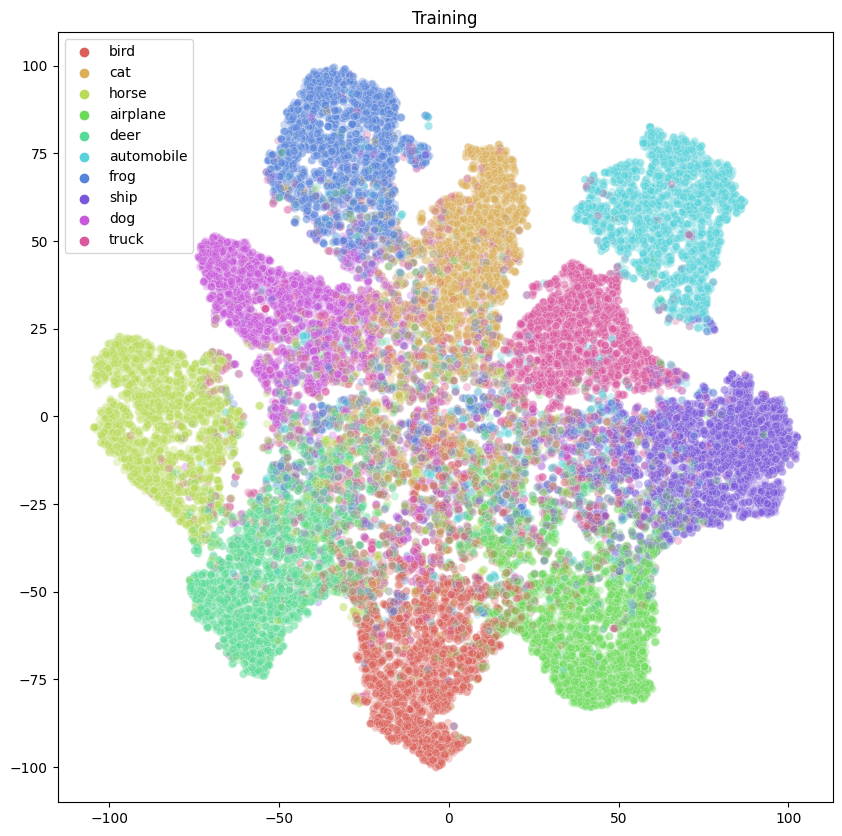

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

def plot_islands(features, labels, classes, title):
    plt.figure(figsize=(10,10))
    features = features.reshape(features.shape[0]*features.shape[1], features.shape[2])
    labels = labels.reshape(labels.shape[0]*labels.shape[1])
    features = TSNE(n_components=2).fit_transform(features)
    sns.scatterplot(x=features[:,0], y=features[:,1], hue=[classes[i] for i in labels], palette=sns.color_palette("hls", 10), legend="full", alpha=0.3)
    plt.title(title)
    plt.show()

plot_islands(features_train, labels_train, classes, "Training")

### Plotting the t-SNE plot for the feature vectors obtained from the fine-tuned pre-trained model on test data

    - We can observe that classes (ship, airplane, automobile and truck) are clustered together in the t-SNE plot for the feature vectors obtained from the fine-tuned pre-trained model on test data.

    - Similarily, classes (cat, frog, dog, horse, deer and bird) are clustered together in the t-SNE plot for the feature vectors obtained from the fine-tuned pre-trained model on test data.

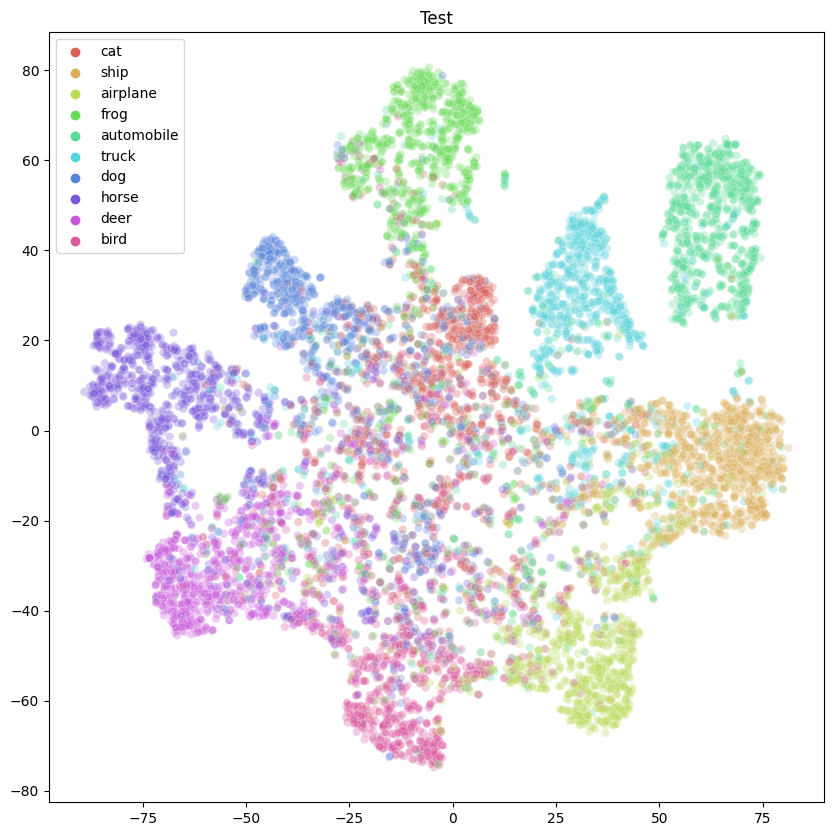

In [69]:
plot_islands(features_test, labels_test, "Test")

## PART2: New Application/ Implementation on a new dataset (EMNIIST)

### Setting up the config for EMNIST dataset.

    - EMNIST is an extension of MNIST dataset to letters(A-Z and a-t) and digits(0-9).
    - It has 814,255 characters, 47 balanced classes.
    - We will be using the EMNIST dataset for the application part and we will observe that the model is able to cluster the letters of both (A-z)   and (a-z) together and digits (0-9) together in the t-SNE plot and the interpretable part-whole hierarchies and conceptual-semantic relationships can be seen.

In [45]:
FLAGS_EMNIST = FLAGS

In [70]:
FLAGS_EMNIST["load_checkpoint_dir"] = "checkpoints/"

In [60]:
FLAGS_EMNIST["dataset"] = "EMNIST"
FLAGS_EMNIST["exp_name"] = "EMNIST"
FLAGS_EMNIST["max_epochs"] = 5
FLAGS_EMNIST["plot_islands"] = True
FLAGS_EMNIST["patch_size"] = 1
FLAGS_EMNIST["patch_dim"] = 128
FLAGS_EMNIST["batch_size"] = 32
FLAGS_EMNIST["supervise"] = False
FLAGS_EMNIST["image_size"] = 28
FLAGS_EMNIST["conv_image_size"] = 7
FLAGS_EMNIST["n_classes"] = 47
FLAGS_EMNIST["n_channels"] = 1
FLAGS_EMNIST["mode"] = "train"
FLAGS_EMNIST["resume_training"] = False
FLAGS_EMNIST["load_checkpoint_dir"] = None
FLAGS_EMNIST["path_to_checkpoint"] = "/workspace/EMNIST_contr.ckpt"
FLAGS_EMNIST

{'dataset': 'EMNIST',
 'exp_name': 'EMNIST',
 'patch_size': 1,
 'patch_dim': 128,
 'batch_size': 32,
 'levels': 2,
 'supervise': False,
 'image_size': 28,
 'conv_image_size': 7,
 'n_channels': 1,
 'n_classes': 47,
 'iters': None,
 'denoise_iter': -1,
 'dropout': 0.3,
 'temperature': 0.07,
 'contr_dim': 512,
 'mode': 'train',
 'learning_rate': 0.05,
 'lr_speed': 2000.0,
 'resume_training': False,
 'load_checkpoint_dir': None,
 'seed': 42,
 'max_epochs': 5,
 'weight_decay': 0.0005,
 'num_workers': 8,
 'num_gpus': 1,
 'limit_train': 1.0,
 'limit_val': 1.0,
 'limit_test': 1.0,
 'plot_islands': True,
 'path_to_checkpoint': '/workspace/EMNIST_contr.ckpt'}

### Custom Transform for EMNIST

In [61]:
class CustomTransformsEMNIST():
    def __init__(self, FLAGS_EMNIST):
        self.FLAGS_EMNIST = FLAGS_EMNIST
        self.train_transforms = {}
        self.test_transforms = {}

        self.train_transforms['EMNIST'] = transforms.Compose([
            transforms.Resize((FLAGS_EMNIST["image_size"], FLAGS_EMNIST["image_size"])),
            transforms.RandAugment(),
            transforms.ToTensor(),
        ])

        self.test_transforms['EMNIST'] = transforms.Compose([
            transforms.Resize((FLAGS_EMNIST["image_size"], FLAGS_EMNIST["image_size"])),
            transforms.ToTensor(),
        ])

### Logging the results to wandb server

In [62]:
wandb_logger = WandbLogger(name=FLAGS_EMNIST["exp_name"], project="DL_Endsem_Application", log_model=True)
wandb_logger.log_hyperparams(FLAGS_EMNIST)
wandb_logger.experiment.config.update(FLAGS_EMNIST)

### Importing the EMNIST DataModule

In [63]:
from pl_bolts.datamodules import EMNISTDataModule

In [64]:
DataModuleWrapper_EMNIST = {
    "EMNIST": EMNISTDataModule,
}

In [65]:
DataModuleWrapper_EMNIST.keys()

dict_keys(['EMNIST'])

In [66]:
if FLAGS_EMNIST["dataset"] not in DataModuleWrapper_EMNIST.keys():
  print("❌ Dataset not compatible")
  quit(0)

### Defining the datamodule to pass to the model

In [67]:
dm_emnist = DataModuleWrapper_EMNIST[FLAGS_EMNIST["dataset"]](
    data_dir='/workspace/data',
    batch_size=FLAGS_EMNIST["batch_size"],
    shuffle=True,
    pin_memory=True,
    drop_last=True,
    split='balanced',
)

In [68]:
ct_emnist = CustomTransformsEMNIST(FLAGS_EMNIST)

In [69]:
if(FLAGS_EMNIST["supervise"]):
    dm_emnist.train_transforms = ct_emnist.train_transforms[FLAGS_EMNIST["dataset"]]
    dm_emnist.val_transforms = ct_emnist.test_transforms[FLAGS_EMNIST["dataset"]]
    dm_emnist.test_transforms = ct_emnist.test_transforms[FLAGS_EMNIST["dataset"]]
else:
    dm_emnist.train_transforms = TwoCropTransform(ct_emnist.train_transforms[FLAGS_EMNIST["dataset"]])
    dm_emnist.val_transforms = TwoCropTransform(ct_emnist.test_transforms[FLAGS_EMNIST["dataset"]])
    dm_emnist.test_transforms = TwoCropTransform(ct_emnist.test_transforms[FLAGS_EMNIST["dataset"]])

### Instantiating the Agglomerator model with the config in FLAGS for EMNIST

In [71]:
model_emnist = Agglomerator(FLAGS_EMNIST).to(device)
checkpoint_dir = os.path.join(os.getcwd(), FLAGS_EMNIST["load_checkpoint_dir"])

### Total number of parameters in the architecture

In [72]:
print("Total trainable parameters:", count_parameters(model_emnist))

Total trainable parameters: 43388155


### Checking if the device is CUDA or not

In [73]:
device  

device(type='cuda')

### Training the model for 5 epochs first due to computational constraints

    PS: This model is time and memory expensive because of its architecture and the number of parameters in it. So, we will be training it for 5 epochs first and then we will be loading the pre-trained model from the checkpoint directory and then we will be fine-tuning it for 5 more epochs.

In [74]:
train_test_freeze(model_emnist, FLAGS_EMNIST, dm_emnist, FLAGS_EMNIST["load_checkpoint_dir"])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                           | Type               | Params
----------------------------------------------------------------------
0 | image_to_tokens                | Sequential         | 111 K 
1 | contrastive_head               | Sequential         | 42.6 M
2 | classification_head_from_contr | Sequential         | 286 K 
3 | bottom_up                      | ColumnNet          | 263 K 
4 | top_down                       | ColumnNet          | 131 K 
5 | attention                      | ConsensusAttention | 0     
--------

Epoch 4: 100%|██████████| 3525/3525 [07:32<00:00,  7.79it/s, loss=0.9, v_num=i16a, Training/LR=0.00203]  

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 3525/3525 [07:35<00:00,  7.73it/s, loss=0.9, v_num=i16a, Training/LR=0.00203]


### Saving the model trained with 5 epochs

In [75]:
torch.save(model_emnist.state_dict(), '/workspace/model_EMNIST.pth')

### Testing the model after 5 epochs and generating plot islands

In [78]:
FLAGS_EMNIST["mode"] = "test"

In [79]:
train_test_freeze(model_emnist, FLAGS_EMNIST, dm_emnist, FLAGS_EMNIST["load_checkpoint_dir"])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 587/587 [00:53<00:00, 11.05it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Test/loss           0.8855159282684326
       Weights/wA          -0.19019384682178497
       Weights/wBU           0.931532084941864
       Weights/wTD          0.04613716900348663
       Weights/wl           0.33745843172073364
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Freezing the model and generating feature vectors and label vectors for the model trained with 5 epochs for both the train and test dataloaders

In [82]:
FLAGS_EMNIST["mode"] = "freeze"
FLAGS_EMNIST["supervise"] = True

In [86]:
train_test_freeze(model_emnist, FLAGS_EMNIST, dm_emnist, FLAGS_EMNIST["load_checkpoint_dir"])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 2820/2820 [01:17<00:00, 36.57it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Test/accuracy         0.13408687710762024
        Test/loss           3.8500771522521973
       Weights/wA           -0.1901872754096985
       Weights/wBU          0.9316180348396301
       Weights/wTD         0.046141158789396286
       Weights/wl           0.33741772174835205
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Training features shape:  (2820, 32, 512)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 705/705 [00:10<00:00, 68.17it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Test/accuracy         0.09751772880554199
        Test/loss           3.8502209186553955
       Weights/wA          -0.19019247591495514
       Weights/wBU          0.9315502643585205
       Weights/wTD         0.046136919409036636
       Weights/wl           0.3374592661857605
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Validation features shape:  (3525, 32, 512)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 587/587 [00:08<00:00, 68.35it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Test/accuracy         0.05856047570705414
        Test/loss            3.850112199783325
       Weights/wA          -0.19019384682178497
       Weights/wBU           0.931532084941864
       Weights/wTD          0.04613716900348663
       Weights/wl           0.33745843172073364
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Test features shape:  (4112, 32, 512)


### Loading the numpy arrays for the feature vectors and labels

In [117]:
features_train_emnist = np.load('/workspace/output/EMNIST/features_train.npy')
labels_train_emnist = np.load('/workspace/output/EMNIST/labels_train.npy')
features_val_emnist = np.load('/workspace/output/EMNIST/features_val.npy')
labels_val_emnist = np.load('/workspace/output/EMNIST/labels_val.npy')
features_test_emnist = np.load('/workspace/output/EMNIST/features_test.npy')
labels_test_emnist = np.load('/workspace/output/EMNIST/labels_test.npy')


### Classes dictionary for EMNIST

In [118]:
classes_emnist = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4',
                  5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
                  10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E',
                  15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J',
                  20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O',
                  25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T',
                  30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y',
                  35: 'Z', 36: 'a', 37: 'b', 38: 'd', 39: 'e',
                  40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q',
                  45: 'r', 46: 't'}

### Some more imports for plotting the t-SNE plot in this case

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

In [119]:
def plot_islands(features, labels, classes, title):
    plt.figure(figsize=(10,10))
    features = features.reshape(features.shape[0]*features.shape[1], features.shape[2])
    labels = labels.reshape(labels.shape[0]*labels.shape[1])
    features = TSNE(n_components=2).fit_transform(features)
    sns.scatterplot(x=features[:,0], y=features[:,1], hue=[classes[i] for i in labels], palette=sns.color_palette("hls", 46), legend="full", alpha=0.3)
    plt.title(title)
    plt.show()

### t-SNE plot for the feature vectors obtained from the model trained with 5 epochs on train data

    - We can observe here some classes are overlapping with each other and some are not. This is because the model is not trained enough and it is not able to cluster the classes properly. But still, we can see some clusters of classes like (A-Z) and (a-z) are overlapping with each other and digits (0-9) are overlapping with each other.

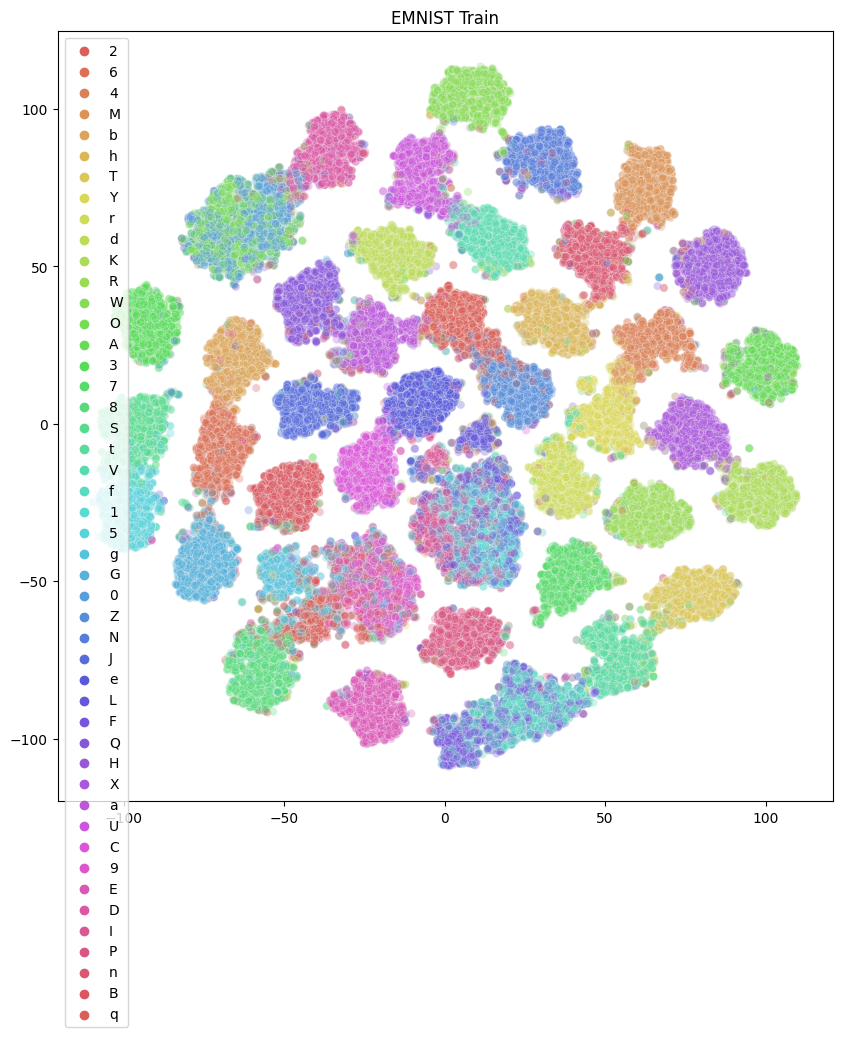

In [120]:
plot_islands(features_train_emnist, labels_train_emnist, classes_emnist, "EMNIST Train")

### Training the same model for another 5 epochs

In [107]:
FLAGS_EMNIST

{'dataset': 'EMNIST',
 'exp_name': 'EMNIST',
 'patch_size': 1,
 'patch_dim': 128,
 'batch_size': 32,
 'levels': 2,
 'supervise': True,
 'image_size': 28,
 'conv_image_size': 7,
 'n_channels': 1,
 'n_classes': 47,
 'iters': None,
 'denoise_iter': -1,
 'dropout': 0.3,
 'temperature': 0.07,
 'contr_dim': 512,
 'mode': 'freeze',
 'learning_rate': 0.05,
 'lr_speed': 2000.0,
 'resume_training': False,
 'load_checkpoint_dir': 'checkpoints/',
 'seed': 42,
 'max_epochs': 5,
 'weight_decay': 0.0005,
 'num_workers': 8,
 'num_gpus': 1,
 'limit_train': 1.0,
 'limit_val': 1.0,
 'limit_test': 1.0,
 'plot_islands': True,
 'path_to_checkpoint': '/workspace/EMNIST_contr.ckpt'}

In [108]:
FLAGS_EMNIST["mode"] = "train"
FLAGS_EMNIST["supervise"] = False
FLAGS_EMNIST

{'dataset': 'EMNIST',
 'exp_name': 'EMNIST',
 'patch_size': 1,
 'patch_dim': 128,
 'batch_size': 32,
 'levels': 2,
 'supervise': False,
 'image_size': 28,
 'conv_image_size': 7,
 'n_channels': 1,
 'n_classes': 47,
 'iters': None,
 'denoise_iter': -1,
 'dropout': 0.3,
 'temperature': 0.07,
 'contr_dim': 512,
 'mode': 'train',
 'learning_rate': 0.05,
 'lr_speed': 2000.0,
 'resume_training': False,
 'load_checkpoint_dir': 'checkpoints/',
 'seed': 42,
 'max_epochs': 5,
 'weight_decay': 0.0005,
 'num_workers': 8,
 'num_gpus': 1,
 'limit_train': 1.0,
 'limit_val': 1.0,
 'limit_test': 1.0,
 'plot_islands': True,
 'path_to_checkpoint': '/workspace/EMNIST_contr.ckpt'}

### Training loop for another 5 epochs for the model trained with 5 epochs

In [110]:
train_test_freeze(model_emnist, FLAGS_EMNIST, dm_emnist, FLAGS_EMNIST["load_checkpoint_dir"])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                           | Type               | Params
----------------------------------------------------------------------
0 | image_to_tokens                | Sequential         | 111 K 
1 | contrastive_head               | Sequential         | 42.6 M
2 | classification_head_from_contr | Sequential         | 286 K 
3 | bottom_up                      | ColumnNet          | 263 K 
4 | top_down                       | ColumnNet          | 131 K 
5 | attention                      | ConsensusAttention | 0     
--------

Epoch 4: 100%|██████████| 3525/3525 [07:26<00:00,  7.90it/s, loss=0.939, v_num=i16a, Training/LR=0.00203]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 3525/3525 [07:29<00:00,  7.85it/s, loss=0.939, v_num=i16a, Training/LR=0.00203]


### Saving the model trained with 10 epochs

In [111]:
torch.save(model_emnist.state_dict(), '/workspace/model_EMNIST.pth')

### Setting up the freeze config again for the model trained with 10 epochs

In [112]:
FLAGS_EMNIST["mode"] = "freeze"
FLAGS_EMNIST["supervise"] = True
FLAGS_EMNIST

{'dataset': 'EMNIST',
 'exp_name': 'EMNIST',
 'patch_size': 1,
 'patch_dim': 128,
 'batch_size': 32,
 'levels': 2,
 'supervise': True,
 'image_size': 28,
 'conv_image_size': 7,
 'n_channels': 1,
 'n_classes': 47,
 'iters': None,
 'denoise_iter': -1,
 'dropout': 0.3,
 'temperature': 0.07,
 'contr_dim': 512,
 'mode': 'freeze',
 'learning_rate': 0.05,
 'lr_speed': 2000.0,
 'resume_training': False,
 'load_checkpoint_dir': 'checkpoints/',
 'seed': 42,
 'max_epochs': 5,
 'weight_decay': 0.0005,
 'num_workers': 8,
 'num_gpus': 1,
 'limit_train': 1.0,
 'limit_val': 1.0,
 'limit_test': 1.0,
 'plot_islands': True,
 'path_to_checkpoint': '/workspace/EMNIST_contr.ckpt'}

### Freezing the model and generating feature vectors and label vectors for the model trained with 10 epochs for both the train and test dataloaders

In [114]:
train_test_freeze(model_emnist, FLAGS_EMNIST, dm_emnist, FLAGS_EMNIST["load_checkpoint_dir"])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 2820/2820 [01:15<00:00, 37.19it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Test/accuracy         0.07203014194965363
        Test/loss            3.850121259689331
       Weights/wA          -0.15909230709075928
       Weights/wBU          1.5643972158432007
       Weights/wTD          0.04232775419950485
       Weights/wl           0.20472706854343414
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Training features shape:  (6932, 32, 512)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 705/705 [00:10<00:00, 68.43it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Test/accuracy         0.05762411281466484
        Test/loss            3.850301742553711
       Weights/wA          -0.15911811590194702
       Weights/wBU           1.564229965209961
       Weights/wTD          0.04232737794518471
       Weights/wl           0.20471732318401337
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Validation features shape:  (7637, 32, 512)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 587/587 [00:08<00:00, 70.64it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Test/accuracy         0.03726575896143913
        Test/loss            3.850175380706787
       Weights/wA          -0.15911799669265747
       Weights/wBU          1.5642132759094238
       Weights/wTD          0.04232727736234665
       Weights/wl           0.20471839606761932
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Test features shape:  (8224, 32, 512)


### Loading the numpy arrays for the feature vectors and labels

In [121]:
features_train_emnist = np.load('/workspace/output/EMNIST/10_epochs/features_train.npy')
labels_train_emnist = np.load('/workspace/output/EMNIST/10_epochs/labels_train.npy')
features_val_emnist = np.load('/workspace/output/EMNIST/10_epochs/features_val.npy')
labels_val_emnist = np.load('/workspace/output/EMNIST/10_epochs/labels_val.npy')
features_test_emnist = np.load('/workspace/output/EMNIST/10_epochs/features_test.npy')
labels_test_emnist = np.load('/workspace/output/EMNIST/10_epochs/labels_test.npy')

### t-SNE plot for the feature vectors obtained from the model trained with 10 epochs on train data

    - We can observe here that the classes are not overlapping with each other and the model is able to cluster the classes properly. We can see some clusters of classes like (A-Z) and (a-z) are overlapping with each other and digits (0-9) are overlapping with each other. But overall, the model is able to cluster the classes properly and the interpretable part-whole hierarchies and conceptual-semantic relationships can be seen as digits are on one side and letters are on the other side of the t-SNE plot.

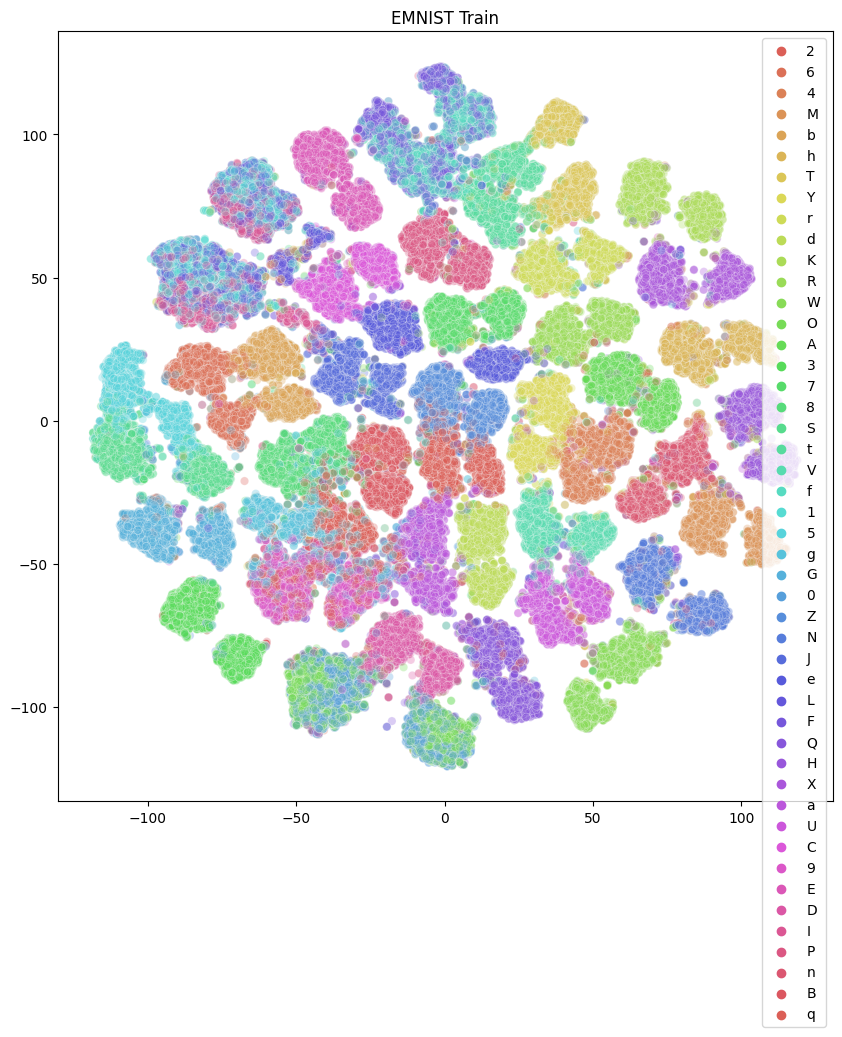

In [122]:
plot_islands(features_train_emnist, labels_train_emnist, classes_emnist, "EMNIST Train")

**END OF NOTEBOOK**